In [ ]:
import os # to navigate through file structures
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 0=all, 1=INFO, 2=WARNING, 3=ERROR, supressing unnecessary warnings

import kagglehub
import tensorflow as tf 
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, RandomFlip, RandomRotation, BatchNormalization, RandomZoom, RandomContrast, RandomTranslation
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.metrics import Precision, Recall, CategoricalAccuracy
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

E0000 00:00:1766797555.106024      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766797555.163345      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("TF version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices("GPU"))

TF version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data

In [ ]:
# Data from: https://www.kaggle.com/datasets/msambare/fer2013
data_path = kagglehub.dataset_download("msambare/fer2013")
print(os.listdir(data_path))

['test', 'train']


## Training Data

In [4]:
# Loading the training data (images and labels)
data_TRAIN = tf.keras.utils.image_dataset_from_directory(data_path + '/train',
                                                        image_size=(48, 48),
                                                        color_mode="grayscale") # want to keep image shape and color
iterator = data_TRAIN.as_numpy_iterator()

Found 28709 files belonging to 7 classes.


I0000 00:00:1766797576.957037      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [5]:
# get a new batch
batch = iterator.next()
#images represented as numpy arrays
print(batch) # batch of 32, is a tuple (images, labels), and 7 classes

(array([[[[255.],
         [255.],
         [254.],
         ...,
         [246.],
         [253.],
         [246.]],

        [[255.],
         [255.],
         [253.],
         ...,
         [242.],
         [248.],
         [247.]],

        [[255.],
         [252.],
         [247.],
         ...,
         [203.],
         [243.],
         [237.]],

        ...,

        [[103.],
         [ 65.],
         [ 35.],
         ...,
         [ 68.],
         [ 73.],
         [ 70.]],

        [[114.],
         [ 92.],
         [ 48.],
         ...,
         [ 74.],
         [ 73.],
         [ 72.]],

        [[113.],
         [115.],
         [ 76.],
         ...,
         [ 81.],
         [ 85.],
         [ 81.]]],


       [[[ 69.],
         [ 82.],
         [ 94.],
         ...,
         [145.],
         [221.],
         [255.]],

        [[ 55.],
         [ 44.],
         [ 70.],
         ...,
         [150.],
         [232.],
         [255.]],

        [[ 78.],
         [105.],
     

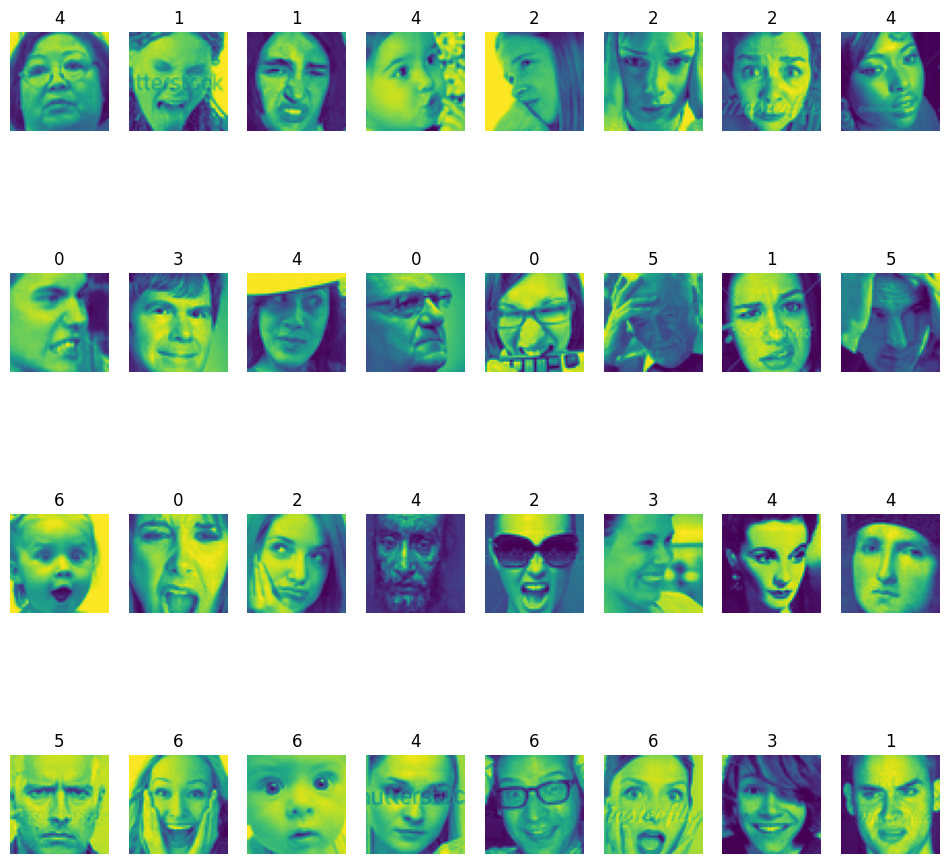

'\n0 --> angry\n1 --> disgust\n2 --> fear\n3 --> happy\n4 --> neutral\n5 --> sad\n6 --> surprise\n'

In [6]:
# show data from batch 0
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(12, 12))
for idx, img in enumerate(batch[0][:32]):

    row = idx // 8
    col = idx % 8

    ax[row, col].imshow(img.astype(int))
    ax[row, col].title.set_text(batch[1][idx])
    ax[row, col].axis("off")

plt.show()

"""
0 --> angry
1 --> disgust
2 --> fear
3 --> happy
4 --> neutral
5 --> sad
6 --> surprise
"""

In [7]:
# max is set to 255
print(batch[0].max())

255.0


In [8]:
# now we want to scale our images to the range [0, 1]
data_TRAIN = data_TRAIN.map(lambda x, y: (x / 255.0, y))
scaling_iterator = data_TRAIN.as_numpy_iterator()

In [9]:
batch = scaling_iterator.next()
print(batch[0].max()) # should be 1.0

1.0


In [10]:
# checking shape 
print(batch[0][0].shape)

(48, 48, 1)


## Test Data

In [11]:
# Loading the testing data (images and labels)
data_TEST = tf.keras.utils.image_dataset_from_directory(data_path + '/test',
                                                        image_size=(48,48),        # keep original size
                                                        color_mode="grayscale",    # force 1 channel
                                                        )

Found 7178 files belonging to 7 classes.


In [12]:
# now we want to scale our images to the range [0, 1]
data_TEST = data_TEST.map(lambda x, y: (x / 255.0, y))
scaling_iterator = data_TEST.as_numpy_iterator()
testing_batch = scaling_iterator.next()
print(testing_batch[0].max()) # should be 1.0

1.0


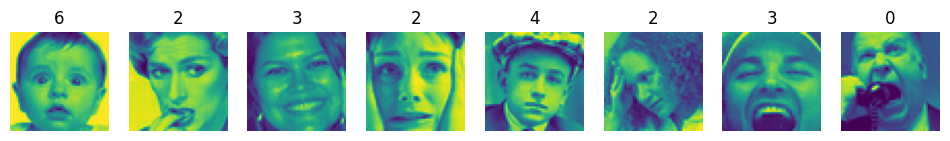

In [13]:
# show data from batch 0 scaled
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(12, 12))
for idx, img in enumerate(testing_batch[0]):

    col = idx % 8

    ax[col].imshow(img) # now not int because we scaled
    ax[col].title.set_text(testing_batch[1][idx])
    ax[col].axis("off")

plt.show()

# Converting Labels to Categories

In [14]:
# need to cast floats to integers and one-hot encode
data_TRAIN = data_TRAIN.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), 7)))
data_TEST  = data_TEST.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), 7)))

batch_check = next(data_TRAIN.as_numpy_iterator())
print("y_batch example:", batch_check[1]) 

y_batch example: [[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


# Partitioning Data

In [15]:
print(len(data_TRAIN))
print(len(data_TEST))

898
225


In [16]:
train_size = int(len(data_TRAIN)*0.6)
val_size = int(len(data_TRAIN)*0.4)
test_size = int(len(data_TEST))

print(f"Train size: {train_size}, Test size: {test_size}, Validation size: {val_size}")

Train size: 538, Test size: 225, Validation size: 359


In [17]:
# taking data
train = data_TRAIN.take(train_size)
test = data_TEST.take(test_size)
val = data_TRAIN.skip(train_size).take(val_size)

print(len(train), len(test), len(val))

538 225 359


# Model



In [18]:
num_classes = 7

# Stronger data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomTranslation(0.05, 0.05),
    RandomContrast(0.1)
])

# Model
model = Sequential([
    Input(shape=(48, 48, 1)),

    # Augmentation layer
    data_augmentation,

    # Block 1
    Conv2D(64, (3,3), padding="same", activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    # Block 2
    Conv2D(128, (3,3), padding="same", activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Block 3
    Conv2D(260, (3,3), padding="same", activation='relu'),
    BatchNormalization(),
    Conv2D(260, (3,3), padding="same", activation='relu'),
    BatchNormalization(),
    Conv2D(260, (3,3), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    # Block 4
    Conv2D(512, (3,3), padding="same", activation='relu'),
    BatchNormalization(),
    Conv2D(512, (3,3), padding="same", activation='relu'),
    BatchNormalization(),
    Conv2D(512, (3,3), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    # Block 5
    Conv2D(512, (3,3), padding="same", activation='relu'),
    BatchNormalization(),
    Conv2D(512, (3,3), padding="same", activation='relu'),
    BatchNormalization(),
    Conv2D(512, (3,3), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.35),

    # Dense layers
    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 260)    │       299,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 260)    │         1,040 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 260)    │       608,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 260)    │         1,040 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 260)    │       608,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 260)    │         1,040 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 260)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 260)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,844,387 (60.44 MB)

 Trainable params: 15,835,915 (60.41 MB)

 Non-trainable params: 8,472 (33.09 KB)

## Training

In [20]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train
model_history = model.fit(
    train,
    epochs=50,
    validation_data=val,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50


E0000 00:00:1766797597.764117      20 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1766797600.549624      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


538/538 ━━━━━━━━━━━━━━━━━━━━ 54s 67ms/step - accuracy: 0.2043 - loss: 2.4067 - val_accuracy: 0.2498 - val_loss: 1.9576 - learning_rate: 0.0010
Epoch 2/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.2551 - loss: 1.9417 - val_accuracy: 0.2968 - val_loss: 1.8294 - learning_rate: 0.0010
Epoch 3/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.2924 - loss: 1.8746 - val_accuracy: 0.3457 - val_loss: 1.7741 - learning_rate: 0.0010
Epoch 4/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.3308 - loss: 1.7858 - val_accuracy: 0.3307 - val_loss: 1.9469 - learning_rate: 0.0010
Epoch 5/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.3759 - loss: 1.6917 - val_accuracy: 0.4144 - val_loss: 1.5848 - learning_rate: 0.0010
Epoch 6/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.4129 - loss: 1.6123 - val_accuracy: 0.3283 - val_loss: 1.9046 - learning_rate: 0.0010
Epoch 7/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.4359 - loss: 1.5658

## Evaluating Accuracy

In [21]:
precision = Precision()
recall = Recall()
accuracy= CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

In [22]:
print(f"precision: {precision.result()}, recall: {recall.result()}, accuracy: {accuracy.result()}")

precision: 0.7249234318733215, recall: 0.5275843143463135, accuracy: 0.6256617307662964


# Saving the Model!

In [23]:
from keras.models import load_model

model.save("emotions_model_ver1.h5")
